In [1]:
# history_returns index=trade_date column=tickers
import numpy as np
import pandas as pd
import statsmodels.api as sm
import fastcluster
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math

# tushare读数据
import tushare as ts
ts.set_token('0742c95bee169abeccdf80bbdce1b2e0cf2ac4d83cbd932b608300fd')
pro = ts.pro_api()
tickers = pro.index_weight(index_code='000016.SH', trade_date=20210630, 
                        fields=["con_code"])["con_code"].to_list()
                        
def get_returns(tickers, start, end):
    stocks = pro.daily(ts_code=tickers[0], start_date=start, end_date=end, fields=['trade_date'])
    for ticker in tickers:
        stock = pro.daily(ts_code=ticker, start_date=start, end_date=end, fields=['trade_date', 'close'])
        stock = stock.rename(columns={"close" : ticker})
        stocks = stocks.merge(stock,on=['trade_date'])
    stocks.set_index(['trade_date'], inplace=True)
    stocks = stocks.iloc[::-1]
    stocks = stocks.dropna()
    returns = stocks.pct_change().iloc[1:] # (pre_close - close)/pre_close
    return returns
start = '20210306'
end = '20230306'
history_returns = get_returns(tickers, start, end)



In [36]:
def get_fut(start, end):
    tickers = ['IF1812.CFX','IH1812.CFX']
    stocks = pro.fut_daily(ts_code=tickers[0], start_date=start, end_date=end, fields=['trade_date'])
    for ticker in tickers:
        stock = pro.fut_daily(ts_code=ticker, start_date=start, end_date=end, fields=['trade_date', 'close'])
        stock = stock.rename(columns={"close" : ticker})
        stocks = stocks.merge(stock,on=['trade_date'])
    stocks.set_index(['trade_date'], inplace=True)
    stocks = stocks.iloc[::-1]
    stocks = stocks.dropna()
    returns = stocks.pct_change().iloc[1:] # (pre_close - close)/pre_close
    return returns

In [3]:
# 函数correlations 输入标准化的returns, nb_clusters 返回sorted_correlations, HPCA_corr
def correlations(returns, nb_clusters):
    ### 分层聚类--使得相关系数大的股票离得更近
    corr = returns.corr(method='pearson')   #股票returns的相关系数
    dist = 1 - corr.values
    tri_a, tri_b = np.triu_indices(len(dist), k=1)
    linkage = fastcluster.linkage(dist[tri_a, tri_b], method='ward') # 最短最长平均法做层次聚类
    permutation = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(linkage, dist[tri_a, tri_b])) # 重新排序切割树 得到叶节点
    sorted_stocks = returns.columns[permutation]
    sorted_corrs = corr.values[permutation, :][:, permutation]
    sorted_correlations = pd.DataFrame(sorted_corrs, index=sorted_stocks, columns=sorted_stocks) # 层次聚类排序后的股票相关系数 靠近斜对角线的系数更大，对应股票相关性更强 

    ### 根据sorted_correlations将股票分成若干簇  注意！如果没有明显的资产分组，HPCA会加强一个虚假的结构
    dist = 1 - sorted_correlations.values
    dim = len(dist)
    tri_a, tri_b = np.triu_indices(dim, k=1)
    linkage = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
    clustering_inds = hierarchy.fcluster(linkage, nb_clusters,
                                        criterion='maxclust')
    clusters = {i: [] for i in range(min(clustering_inds),
                                    max(clustering_inds) + 1)}
    for i, v in enumerate(clustering_inds):
        clusters[v].append(i)

    permutation = sorted([(min(elems), c) for c, elems in clusters.items()],
                        key=lambda x: x[0], reverse=False)
    sorted_clusters = {}
    for cluster in clusters:
        sorted_clusters[cluster] = clusters[permutation[cluster - 1][1]]
    # 画每簇的成员股票累计收益率 簇内股票收益率相关性强 累计收益率曲线相似 注意！若相关系数不大，曲线不相似，可以增大簇的个数
    stock_to_cluster = {}
    for cluster in sorted_clusters:
        cluster_members = sorted_correlations.columns[sorted_clusters[cluster]].tolist()
        for stock in cluster_members:
            stock_to_cluster[stock] = cluster
    ### 簇内股票收益率矩阵 右乘 簇内相关系数矩阵的第一特征向量 除以 最大特征值的平方 得收益率降维后的值
    eigen_clusters = {}
    for cluster in clusters:
        cluster_members = sorted_correlations.columns[
            sorted_clusters[cluster]].tolist()
        corr_cluster = sorted_correlations.loc[
            cluster_members, cluster_members]
        cluster_returns = returns[cluster_members]
        eigenvals, eigenvecs = np.linalg.eig(corr_cluster.values) # 簇内相关系数的特征值、特征向量
        idx = eigenvals.argsort()[::-1]
        eigenvals, eigenvecs = eigenvals[idx], eigenvecs[:, idx]
        val1, vec1= eigenvals[0], eigenvecs[:, 0] # 簇内相关系数的最大特征值、第一特征向量
        F1 = (1 / np.sqrt(val1)) * np.dot(cluster_returns.values,vec1) # 得簇内收益率降维后的值 392*10 × 10*1 = 392*1  将股票收益率整合到方差最大的线性方向上
        eigen_clusters[cluster] = F1
    # 股票收益率和对应簇内降维收益率的线性回归斜率
    betas = {}
    for stock in returns.columns:
        stock_returns = returns[stock]
        cluster_F1 = eigen_clusters[stock_to_cluster[stock]]
        reg = LinearRegression(fit_intercept=False).fit(
            cluster_F1.reshape(-1, 1), stock_returns)
        beta = reg.coef_[0]
        betas[stock] = beta 
    ### 更新不同簇的股票之间的相关系数 体现出簇间相关性
    HPCA_corr = sorted_correlations.copy()
    for stock_1 in HPCA_corr.columns:
        beta_1 = betas[stock_1]
        F1_1 = eigen_clusters[stock_to_cluster[stock_1]]
        for stock_2 in HPCA_corr.columns:
            beta_2 = betas[stock_2]
            F1_2 = eigen_clusters[stock_to_cluster[stock_2]]
            if stock_to_cluster[stock_1] != stock_to_cluster[stock_2]: # 对不同簇股票的相关系数调整 体现簇间差异
                rho_sector = np.corrcoef(F1_1, F1_2)[0, 1] # 簇间相关性
                mod_rho = beta_1 * beta_2 * rho_sector
                HPCA_corr.at[stock_1, stock_2] = mod_rho
    return sorted_correlations, HPCA_corr

In [4]:
# KMO测度函数 输入相关系数矩阵 返回kmo_value测度值
def kmo(dataset_corr):
    corr_inv = np.linalg.inv(dataset_corr)
    nrow_inv_corr, ncol_inv_corr = dataset_corr.shape
    A = np.ones((nrow_inv_corr, ncol_inv_corr))
    for i in range(0, nrow_inv_corr, 1):
        for j in range(i, ncol_inv_corr, 1):
            A[i, j] = -(corr_inv[i, j]) / (math.sqrt(corr_inv[i, i] * corr_inv[j, j]))
            A[j, i] = A[i, j]
    dataset_corr = np.asarray(dataset_corr)
    kmo_num = np.sum(np.square(dataset_corr)) - np.sum(np.square(np.diagonal(A)))
    kmo_denom = kmo_num + np.sum(np.square(A)) - np.sum(np.square(np.diagonal(A)))
    kmo_value = kmo_num / kmo_denom
    return kmo_value

In [51]:
# 确定window_length
window_lengths = np.array([60,100,150,200,250,300,340,380]) # 初始化选定取值区间
examine_0 = pd.DataFrame(index=history_returns.index,columns=window_lengths)
for window_length in window_lengths:
    max_p_value = 0
    for cur_num in range(window_length, history_returns.shape[0]):
        returns = history_returns.iloc[cur_num-window_length:cur_num]
        # Bartlett's球状检验
        # 若P值远小于0.05,拒绝原假设,说明变量之间有相关关系,可以做主成分分析
        from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
        
        chi_square_value, p_value = calculate_bartlett_sphericity(returns)
        if p_value > max_p_value:max_p_value = p_value
        
        # KMO检验
        # 检查变量间的相关性和偏相关性，取值在0-1之间；KMO统计量越接近1，变量间的相关性越强，偏相关性越弱，主成分分析的效果越好。
        from factor_analyzer.factor_analyzer import calculate_kmo
        
        kmo_all, kmo_model = calculate_kmo(returns)
        examine_0.loc[history_returns.index[cur_num-1]][window_length] = kmo_model
    print('window_length={} max_p_value={}'.format(window_length,max_p_value))
examine_0.astype('float64').describe()

d:\anaconda\lib\site-packages\factor_analyzer\utils.py:245: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  "The inverse of the variance-covariance matrix "


window_length=60 max_p_value=1.5799723222806901e-83
window_length=100 max_p_value=1.3873145680196791e-208
window_length=150 max_p_value=0
window_length=200 max_p_value=0
window_length=250 max_p_value=0
window_length=300 max_p_value=0
window_length=340 max_p_value=0
window_length=380 max_p_value=0


,60,100,150,200,250,300,340,380
count,407.000000,367.000000,317.000000,267.000000,217.000000,167.000000,127.000000,87.000000
mean,0.604131,0.834275,0.893026,0.917139,0.929492,0.934619,0.937209,0.938649
std,0.084621,0.047545,0.032286,0.020498,0.011606,0.008182,0.005109,0.002830
min,0.387226,0.727270,0.824602,0.865594,0.905927,0.919058,0.929320,0.933246
25%,0.541445,0.782878,0.859328,0.909665,0.916538,0.926999,0.932952,0.936887
50%,0.604419,0.855404,0.908448,0.924609,0.932357,0.937364,0.934875,0.938328
75%,0.672321,0.875257,0.917689,0.932663,0.940202,0.942011,0.942064,0.941436
max,0.794592,0.889793,0.924633,0.939229,0.943409,0.944924,0.943926,0.944789


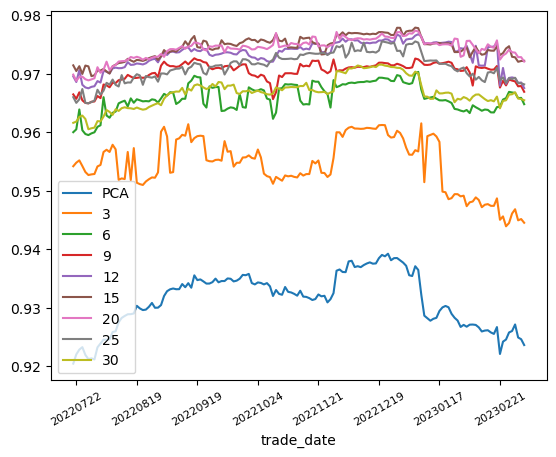

,PCA,3,6,9,12,15,20,25,30
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,0.931274,0.954479,0.965912,0.970215,0.973227,0.974466,0.974240,0.971181,0.966802
std,0.004724,0.004549,0.002407,0.001796,0.002303,0.001965,0.001882,0.002497,0.002537
min,0.920458,0.943909,0.959488,0.964902,0.967477,0.969553,0.968744,0.964911,0.960488
25%,0.927585,0.951956,0.964248,0.969361,0.971920,0.973220,0.973366,0.969504,0.965436
50%,0.932052,0.954769,0.965734,0.970874,0.973756,0.974815,0.974622,0.971433,0.966778
75%,0.934698,0.958928,0.968114,0.971402,0.975137,0.975830,0.975311,0.973223,0.967935
max,0.939229,0.961490,0.970278,0.972600,0.976708,0.977839,0.977327,0.975491,0.971515


In [10]:
# kmo检验法 确定nb_cluster
window_length = 200 #根据上面结果,结合实际,确定window_length
nb_clusters = [3,6,9,12,15,20,25,30] # 初始化选定取值区间
original_returns = history_returns[-350:]
examine_1 = pd.DataFrame(index=original_returns.index,columns=['PCA']+ nb_clusters) 
for nb_cluster in nb_clusters:
    for cur_num in range(window_length, original_returns.shape[0]):
        returns = original_returns.iloc[cur_num-window_length:cur_num]
        returns = (returns - returns.mean()) / returns.std()
        sorted_correlations, HPCA_corr = correlations(returns, nb_cluster)
        examine_1.loc[original_returns.index[cur_num-1]]['PCA'] = kmo(sorted_correlations)
        examine_1.loc[original_returns.index[cur_num-1]][nb_cluster] = kmo(HPCA_corr)    
examine_1.plot()
plt.xticks(rotation=30, fontsize=8)
plt.show()
examine_1.astype('float64').describe()


In [77]:
# 变化度 确定nb_cluster
nb_clusters =np.arange(6,22)
cur = pd.DataFrame(index=history_returns.columns,columns=nb_clusters)
diff = pd.DataFrame(np.zeros((50,len(nb_clusters))), index=history_returns.columns,columns=nb_clusters)
for nb_cluster in nb_clusters:
    for cur_num in range(window_length):
        returns = history_returns.iloc[cur_num:cur_num+200]
        returns = (returns - returns.mean())/returns.std() 
        ### 分层聚类--使得相关系数大的股票离得更近
        corr = returns.corr(method='pearson')   #股票returns的相关系数
        dist = 1 - corr.values
        tri_a, tri_b = np.triu_indices(len(dist), k=1)
        linkage = fastcluster.linkage(dist[tri_a, tri_b], method='ward') # 最短最长平均法做层次聚类
        permutation = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(linkage, dist[tri_a, tri_b])) # 重新排序切割树 得到叶节点
        sorted_stocks = returns.columns[permutation]
        sorted_corrs = corr.values[permutation, :][:, permutation]
        sorted_correlations = pd.DataFrame(sorted_corrs, index=sorted_stocks, columns=sorted_stocks) # 层次聚类排序后的股票相关系数 靠近斜对角线的系数更大，对应股票相关性更强 
        ### 根据sorted_correlations将股票分成若干簇  注意！如果没有明显的资产分组，HPCA会加强一个虚假的结构
        dist = 1 - sorted_correlations.values
        dim = len(dist)
        tri_a, tri_b = np.triu_indices(dim, k=1)
        linkage = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
        clustering_inds = hierarchy.fcluster(linkage, nb_cluster,
                                            criterion='maxclust')
        clusters = {i: [] for i in range(min(clustering_inds),
                                        max(clustering_inds) + 1)}
        for i, v in enumerate(clustering_inds):
            clusters[v].append(i)

        permutation = sorted([(min(elems), c) for c, elems in clusters.items()],
                            key=lambda x: x[0], reverse=False)
        sorted_clusters = {}
        for cluster in clusters:
            sorted_clusters[cluster] = clusters[permutation[cluster - 1][1]]
            
        stock_to_cluster = {}
        for cluster in sorted_clusters:
            cluster_members = set(sorted_correlations.columns[sorted_clusters[cluster]])
            for stock in cluster_members:
                if pd.isna(cur.loc[stock][nb_cluster]):
                    cur.loc[stock][nb_cluster] = cluster_members
                    continue
                if cluster_members != set(cur.loc[stock][nb_cluster]):
                    cur.loc[stock][nb_cluster] = cluster_members
                    diff.loc[stock][nb_cluster] += 1
diff.describe()



,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,44.660000,39.740000,35.620000,38.260000,34.260000,34.06000,26.980000,27.920000,27.060000,23.460000,22.700000,22.620000,20.460000,18.060000,22.920000,16.800000
std,19.323888,19.107441,18.870006,19.699591,21.043017,23.58693,21.874867,22.816786,22.456679,20.034878,19.072632,19.392708,18.736857,18.192183,20.704766,13.525486
min,2.000000,2.000000,4.000000,10.000000,4.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,34.000000,25.000000,16.000000,17.000000,13.00000,13.000000,10.000000,6.000000,2.000000,2.000000,2.000000,0.500000,0.500000,6.750000,8.000000
50%,37.500000,41.000000,36.000000,42.000000,31.000000,28.00000,21.500000,25.500000,23.000000,22.000000,21.000000,25.500000,20.000000,12.000000,14.000000,14.000000
75%,59.000000,51.000000,48.000000,49.000000,47.000000,46.00000,36.000000,47.000000,46.000000,42.000000,40.000000,38.000000,38.500000,37.500000,44.500000,26.000000
max,73.000000,73.000000,68.000000,70.000000,71.000000,76.00000,69.000000,67.000000,65.000000,59.000000,62.000000,69.000000,59.000000,57.000000,61.000000,57.000000


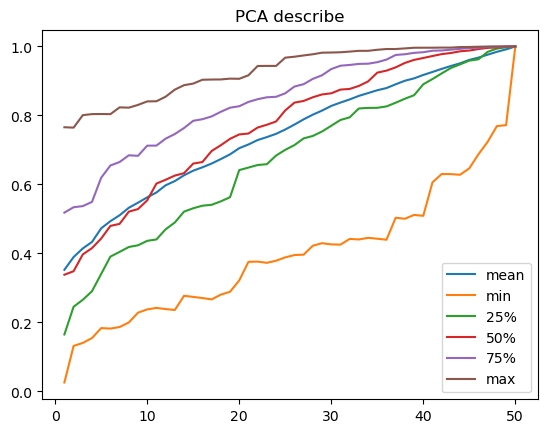

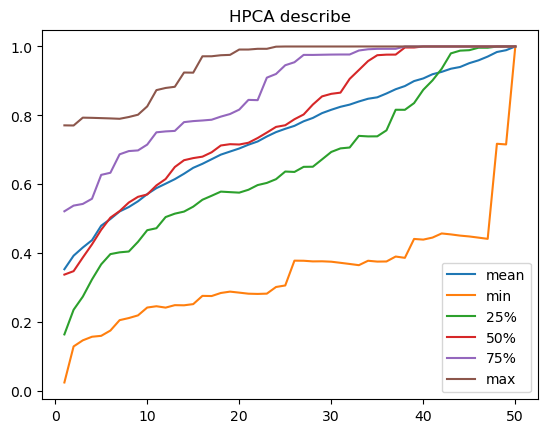

In [78]:
# adj_R^2 确定n_component
original_returns = history_returns.iloc[-window_length:]
returns = (original_returns - original_returns.mean())/original_returns.std()
adj_r2 = pd.DataFrame(index=returns.columns,columns=np.arange(1,51))
adj_r2_H = pd.DataFrame(index=returns.columns,columns=np.arange(1,51))

for n_component in range(1,51):
    sorted_correlations, HPCA_corr= correlations(returns,19)
    eigenvals, eigenvecs = np.linalg.eig(sorted_correlations)
    idx = eigenvals.argsort()[::-1]   
    pca_eigenvecs = eigenvecs[:, idx][:, :n_component]  
    fct = np.dot(original_returns/original_returns.std(),pca_eigenvecs)
    eigenvals_H, eigenvecs_H = np.linalg.eig(HPCA_corr)
    idx_H = eigenvals_H.argsort()[::-1]   
    hpca_eigenvecs = eigenvecs_H[:, idx_H][:, :n_component]  
    fct_H = np.dot(original_returns/original_returns.std(),hpca_eigenvecs)
    for stock in sorted_correlations.columns:
        OLSmodel_P = sm.OLS(original_returns[stock], fct).fit()
        adj_r2.loc[stock][n_component] = OLSmodel_P.rsquared_adj
        OLSmodel_H = sm.OLS(original_returns[stock], fct_H).fit()
        adj_r2_H.loc[stock][n_component] = OLSmodel_H.rsquared_adj
des_P = adj_r2.astype('float64').describe()
des_H = adj_r2_H.astype('float64').describe()
des_P.drop(index=['count','std']).T.plot()
plt.title('PCA describe')
plt.show()
des_H.drop(index=['count','std']).T.plot()
plt.title('HPCA describe')
plt.show()


date: 20220113
HPCA：long: 600276.SH: 0.2842  600690.SH: 0.3137  601398.SH: 0.4021  short: 603288.SH: 0.2489  600809.SH: 0.2654  601888.SH: 0.2701  600030.SH: 0.2155  cur ret：0.0227   cum ret：0.0227
PCA：long: 601211.SH: 0.5255  601398.SH: 0.4745  short: 600196.SH: 0.4752  600030.SH: 0.5248  cur ret：0.0042   cum ret：0.0042
hpca&pca cur ret：0.0339   cum ret：0.0339
date: 20220114
HPCA：long: 601628.SH: 0.4003  600030.SH: 0.5997  short: 601818.SH: 1.0000  cur ret：0.0054   cum ret：0.0282
PCA：long: 603259.SH: 0.2745  600570.SH: 0.1977  600030.SH: 0.3371  601668.SH: 0.1907  short: 603501.SH: 0.2346  600690.SH: 0.2545  601818.SH: 0.2892  601688.SH: 0.2217  cur ret：-0.0050   cum ret：-0.0008
hpca&pca cur ret：0.0114   cum ret：0.0457
date: 20220117
HPCA：short: 600030.SH: 1.0000  cur ret：-0.0115   cum ret：0.0164
PCA：long: 601995.SH: 1.0000  short: 600030.SH: 0.5366  600588.SH: 0.4634  cur ret：-0.0092   cum ret：-0.0100
hpca&pca cur ret：-0.0121   cum ret：0.0330
date: 20220118
HPCA：long: 600690.SH: 0.33

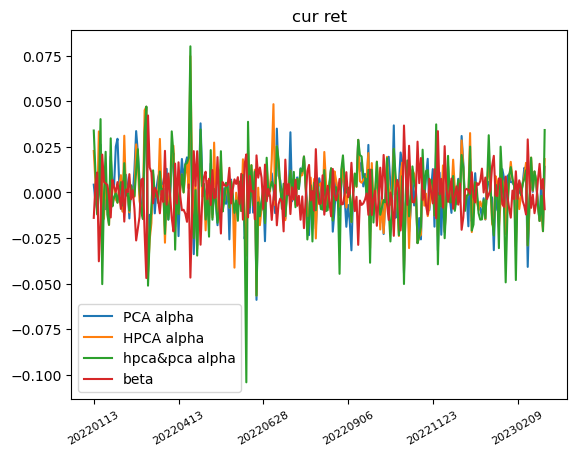

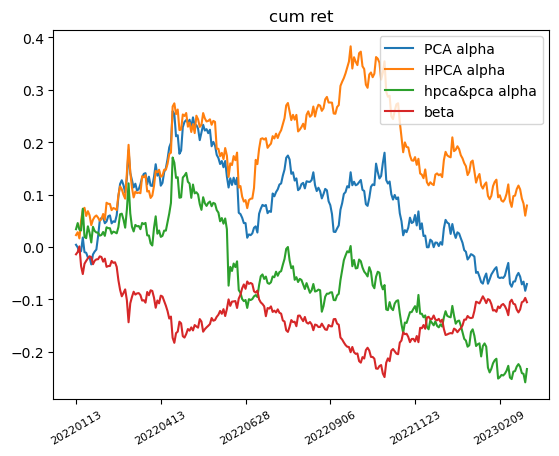

In [11]:
# 策略计算得到zscores
cur_ret_P = []
cur_ret_H = []
cur_ret__ = [] # 市场收益率
cur_ret_ = [] # HPCA&PCA交叉选股
cum_ret_P = [0]
cum_ret_H = [0]
cum_ret__ = [0]
cum_ret_ = [0]

date = []
# 三个系数由前面的数据结果分析得出
window_length = 200
nb_cluster = 19
n_component = 30

for cur_num in range(window_length, history_returns.shape[0]):
    date.append(history_returns.index[cur_num-1])
    print('date:', date[-1])
    # 获取标准化实验数据
    original_returns = history_returns.iloc[cur_num-window_length:cur_num]
    returns = (original_returns - original_returns.mean())/original_returns.std()
    sorted_correlations, HPCA_corr = correlations(returns,nb_cluster)
    sorted_returns = original_returns[sorted_correlations.columns] 
    eigenvals_P, eigenvecs_P = np.linalg.eig(sorted_correlations)
    idx_P = eigenvals_P.argsort()[::-1]   
    pca_eigenvecs = eigenvecs_P[:, idx_P][:, :n_component]  
    fct_P = np.dot(sorted_returns/sorted_returns.std(),pca_eigenvecs)
    OLSmodels_P = {stock: sm.OLS(sorted_returns[stock], fct_P).fit() for stock in sorted_returns.columns}
    resids_P = pd.DataFrame({stock: model_P.resid for stock, model_P in OLSmodels_P.items()})
    zscores_P = ((resids_P - resids_P.mean()) / resids_P.std()).iloc[-1]
    long_P = zscores_P[zscores_P < 0]
    short_P = zscores_P[zscores_P > 0]

    eigenvals_H, eigenvecs_H = np.linalg.eig(HPCA_corr)
    idx_H = eigenvals_H.argsort()[::-1]   
    hpca_eigenvecs = eigenvecs_H[:, idx_H][:, :n_component]  
    fct_H = np.dot(sorted_returns/sorted_returns.std(),hpca_eigenvecs)
    OLSmodels_H = {stock: sm.OLS(sorted_returns[stock], fct_H).fit() for stock in sorted_returns.columns}
    resids_H = pd.DataFrame({stock: model_H.resid for stock, model_H in OLSmodels_H.items()}) 
    zscores_H = ((resids_H - resids_H.mean()) / resids_H.std()).iloc[-1]
    long_H = zscores_H[zscores_H < 0]
    short_H = zscores_H[zscores_H > 0]
    ########################################################
    # HPCA选股
    print('HPCA：', end='')
    if len(long_H) != 0:
        weights_long_H = long_H * (1 / long_H.sum())
        print('long:', end=' ')
        for stock, weight in weights_long_H.items():
            print(stock+': %.4f'%weight, end='  ')
    else: weights_long_H = long_H
    if len(short_H) != 0:
        weights_short_H = short_H * (1 / short_H.sum())
        print('short:', end=' ')
        for stock, weight in weights_short_H.items():
            print(stock+': %.4f'%weight, end='  ')
    else: weights_short_H = short_H
    cur_ret_H.append((sum(weights_long_H*history_returns[weights_long_H.index].iloc[cur_num]) - sum(weights_short_H*history_returns[weights_short_H.index].iloc[cur_num]))/2 - history_returns.iloc[cur_num].mean())
    cum_ret_H.append((1+cum_ret_H[-1])*(1+cur_ret_H[-1])-1)
    print('cur ret：%.4f'%cur_ret_H[-1],end='   ')
    print('cum ret：%.4f'%cum_ret_H[-1])
    # PCA选股
    print('PCA：', end='')
    if len(long_P) != 0:
        weights_long_P =  long_P * (1 / long_P.sum())
        print('long:', end=' ')
        for stock, weight in weights_long_P.items():
            print(stock+': %.4f'%weight, end='  ')
    else: weights_long_P = long_P
    if len(short_P) != 0:
        weights_short_P =  short_P * (1 / short_P.sum())
        print('short:', end=' ')
        for stock, weight in weights_short_P.items():
            print(stock+': %.4f'%weight, end='  ')
    else: weights_short_P = short_P
    cur_ret_P.append((sum(weights_long_P*history_returns[weights_long_P.index].iloc[cur_num]) - sum(weights_short_P*history_returns[weights_short_P.index].iloc[cur_num]))/2 - history_returns.iloc[cur_num].mean())
    cum_ret_P.append((1+cum_ret_P[-1])*(1+cur_ret_P[-1])-1)
    cur_ret__.append(history_returns.iloc[cur_num].mean())
    cum_ret__.append((1+cum_ret__[-1])*(1+cur_ret__[-1])-1)
    print('cur ret：%.4f'%cur_ret_P[-1],end='   ')
    print('cum ret：%.4f'%cum_ret_P[-1])
    # 交叉选股
    print('hpca&pca', end=' ')
    if len(long_P.index.intersection(long_H.index)) == 0 and len(short_P.index.intersection(short_H.index)) == 0:
        cur_ret_.append(- history_returns.iloc[cur_num].mean())
    elif len(long_P.index.intersection(long_H.index)) == 0 and len(short_P.index.intersection(short_H.index)) != 0:
        cur_ret_.append(- history_returns[short_P.index.intersection(short_H.index)].iloc[cur_num].mean() - history_returns.iloc[cur_num].mean())
    elif len(long_P.index.intersection(long_H.index)) != 0 and len(short_P.index.intersection(short_H.index)) == 0:
        cur_ret_.append(history_returns[long_P.index.intersection(long_H.index)].iloc[cur_num].mean() - history_returns.iloc[cur_num].mean())
    else:
        cur_ret_.append((history_returns[long_P.index.intersection(long_H.index)].iloc[cur_num].mean() - history_returns[short_P.index.intersection(short_H.index)].iloc[cur_num].mean())/2 - history_returns.iloc[cur_num].mean())
    cum_ret_.append((1+cum_ret_[-1])*(1+cur_ret_[-1])-1)
    print('cur ret：%.4f'%cur_ret_[-1],end='   ')
    print('cum ret：%.4f'%cum_ret_[-1])
    ########################################################


df_cur = pd.DataFrame(np.array([cur_ret_P[:],cur_ret_H[:],cur_ret_[:],cur_ret__[:]]).T, columns=['PCA alpha','HPCA alpha','hpca&pca alpha','beta'], index=np.array(date))
df_cur.plot()
plt.title('cur ret')
plt.xticks(rotation=30, fontsize=8)
plt.show()
df_cum = pd.DataFrame(np.array([cum_ret_P[1:],cum_ret_H[1:],cum_ret_[1:],cum_ret__[1:]]).T, columns=['PCA alpha','HPCA alpha','hpca&pca alpha','beta'], index=np.array(date))
df_cum.plot()
plt.title('cum ret')
plt.xticks(rotation=30, fontsize=8)
plt.show()

In [21]:
#PCA 的第一个eigenvector做一些分析，随时间的变化，主要的weight的股票是哪些， 有没有负相关的股票，如果有是哪些，如果短暂的出现，是否应该考虑去除
2. PCA的第一个特征向量和IF/IH的期货的相关性如何？


from factor_analyzer.factor_analyzer import calculate_kmo

for 
    kmo_all, kmo_model = calculate_kmo(returns)
    eigenvals_P, eigenvecs_P = np.linalg.eig(returns.corr())
    idx_P = eigenvals_P.argsort()[::-1]   
    pca_eigenvecs = eigenvecs_P[:, idx_P][:, :n_component]  
    returns = returns.dot(pca_eigenvecs)

NameError: name 'H' is not defined

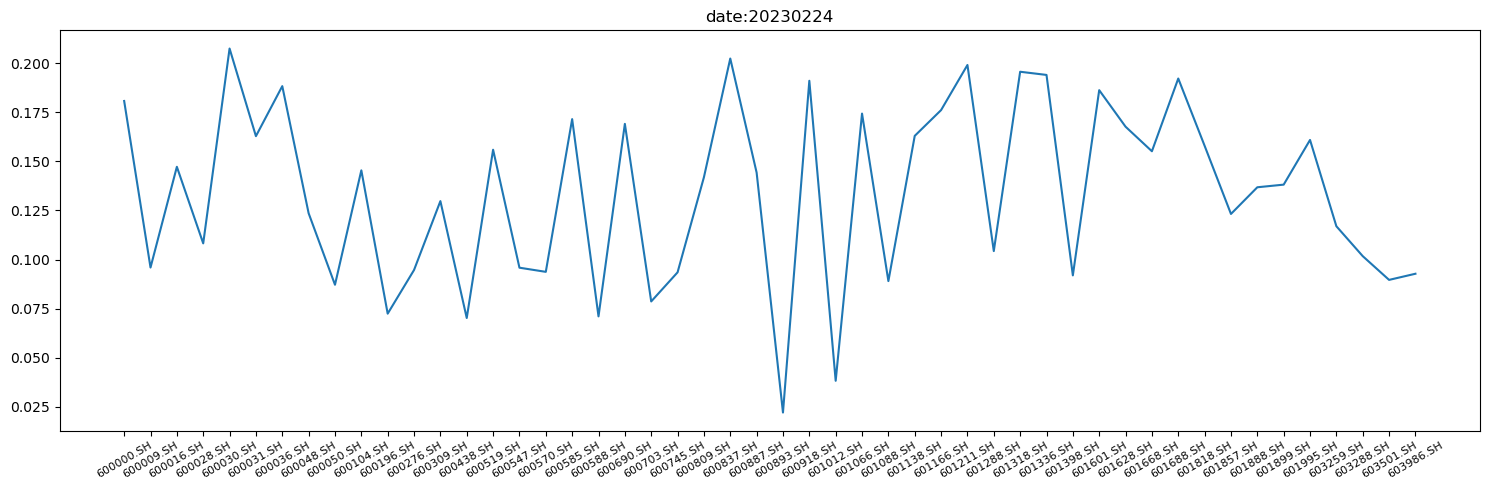

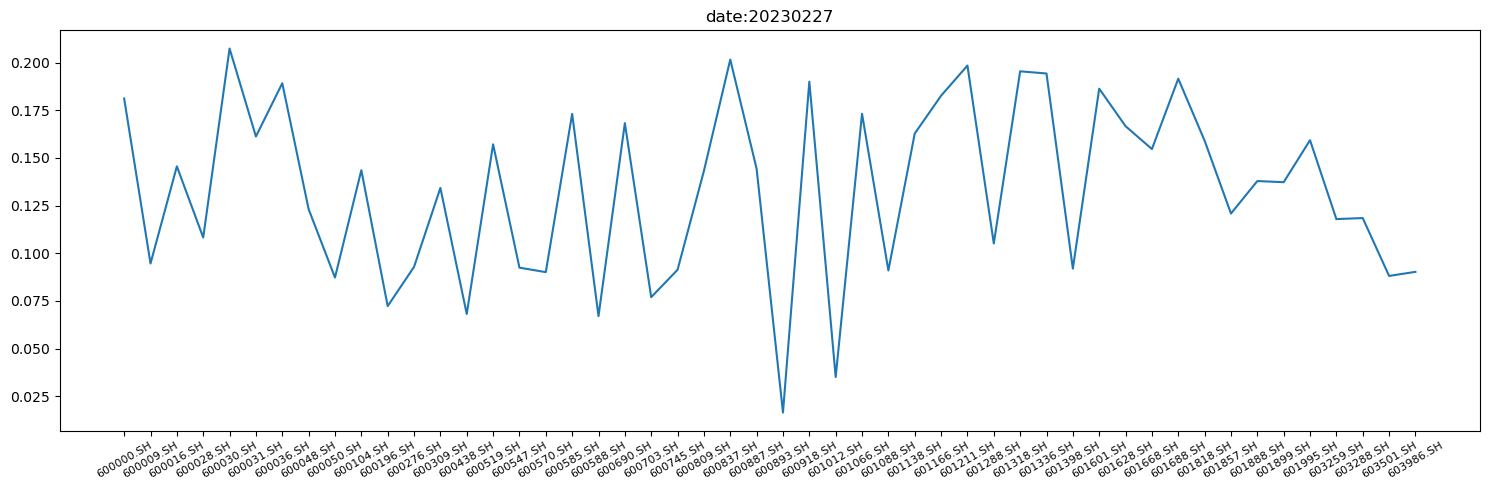

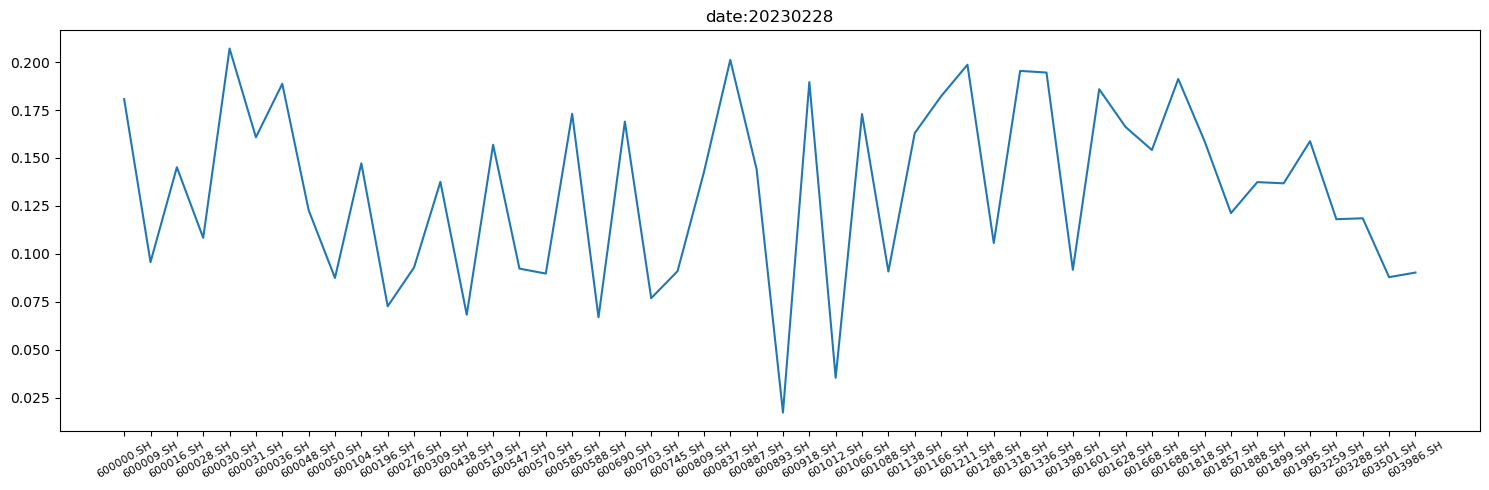

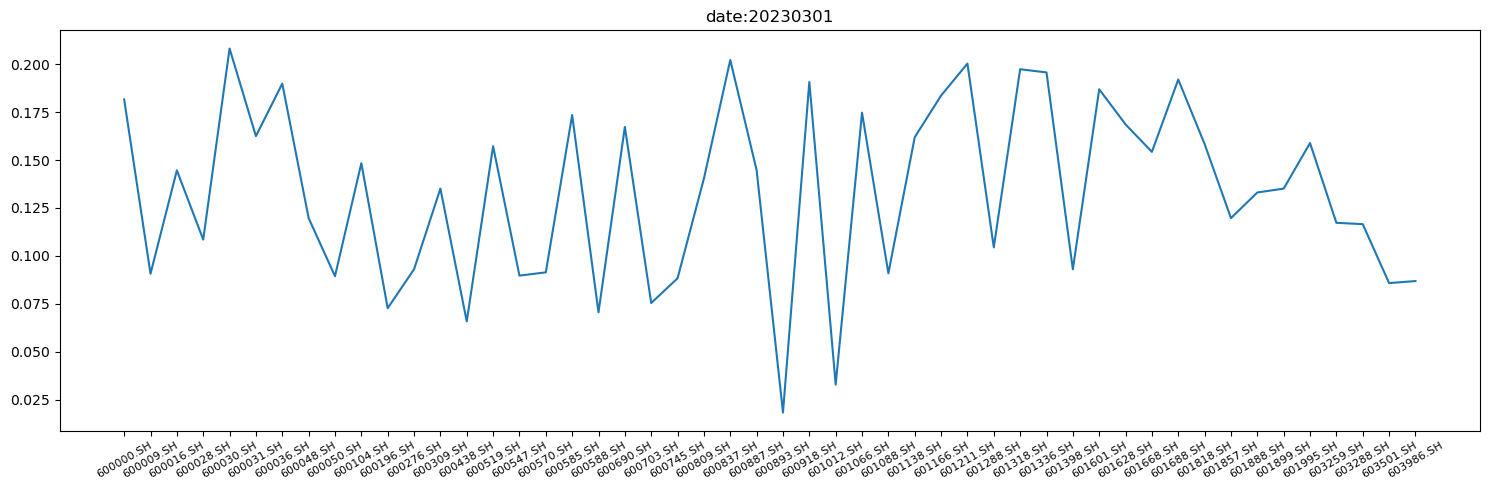

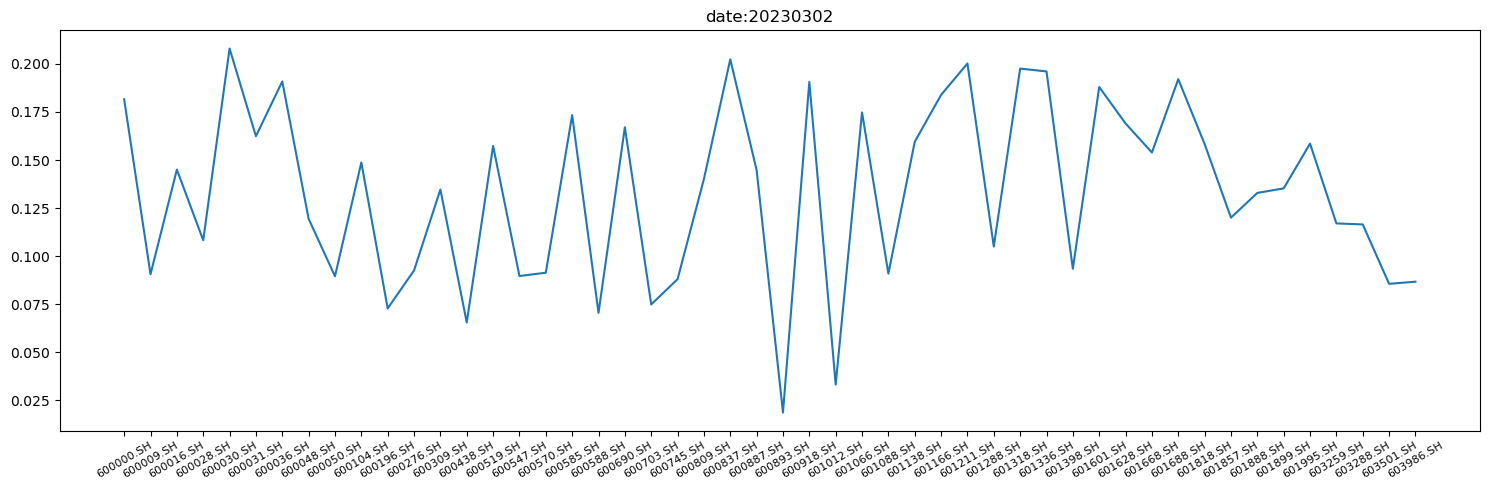

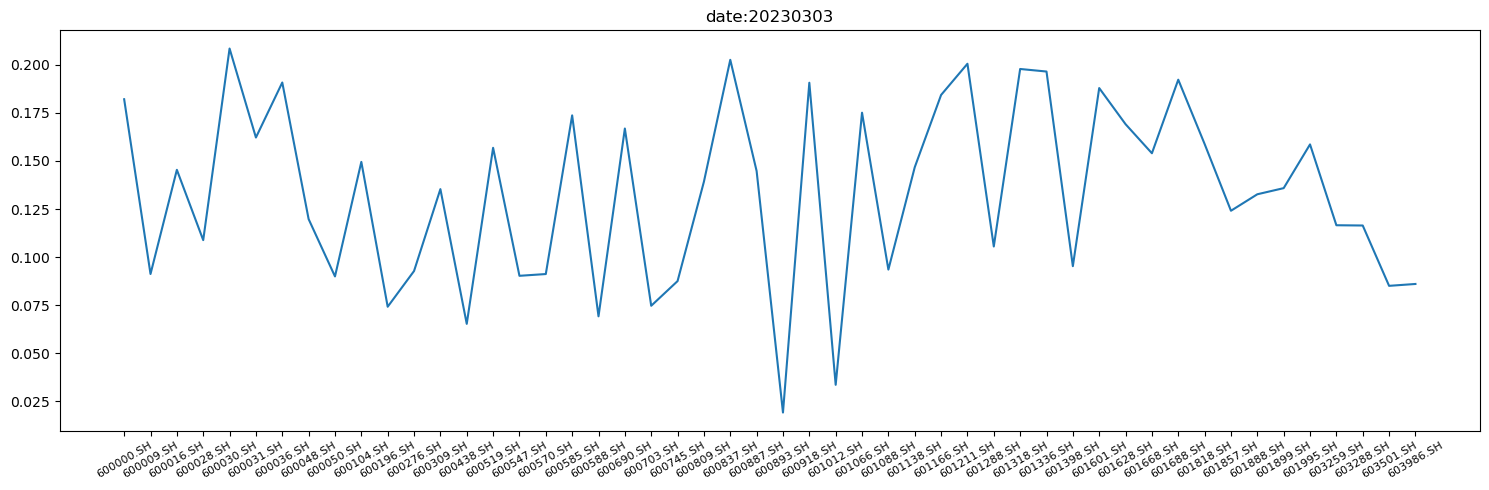

In [49]:
# 第一主成分实验
date = []
weight = pd.DataFrame(columns=history_returns.columns, index=history_returns.index)
for cur_num in range(window_length, history_returns.shape[0]):
    date.append(history_returns.index[cur_num-1])
    # 获取标准化实验数据
    original_returns = history_returns.iloc[cur_num-window_length:cur_num]
    returns = (original_returns - original_returns.mean())/original_returns.std()
    eigenvals_P, eigenvecs_P = np.linalg.eig(returns.corr())
    idx_P = eigenvals_P.argsort()[::-1]   
    pca_eigenvecs = eigenvecs_P[:, idx_P][:, 0]
    weight.loc[date[-1]] = list(pca_eigenvecs.reshape(-1,1))
    if cur_num > 460:
        fig, ax = plt.subplots(figsize=(15, 5),
                            tight_layout=True)
        plt.plot(pca_eigenvecs, label='PCA')
        plt.xticks(range(0,50), returns.columns, rotation=30, fontsize=8)
        plt.title('date:{}'.format(date[-1]))
        plt.show()

In [43]:
history_returns

,600000.SH,600009.SH,600016.SH,600028.SH,600030.SH,600031.SH,600036.SH,600048.SH,600050.SH,600104.SH,...,601688.SH,601818.SH,601857.SH,601888.SH,601899.SH,601995.SH,603259.SH,603288.SH,603501.SH,603986.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
20210309,-0.001860,-0.022623,-0.003846,-0.008772,-0.032192,-0.071015,-0.028640,-0.007905,-0.022222,0.000489,...,-0.010490,-0.012136,-0.008869,0.011828,0.003749,-0.064158,0.008792,-0.030779,-0.038092,-0.041878
20210310,-0.000932,0.002611,0.001931,-0.022124,-0.002526,0.026023,0.015464,-0.010624,-0.004545,-0.023460,...,-0.005300,-0.009828,-0.017897,0.061391,-0.020542,0.001042,0.061643,0.004100,0.013751,-0.013609
20210311,0.016791,0.020135,0.007707,0.013575,0.014352,0.007926,0.055228,0.006711,0.009132,0.004505,...,0.010065,0.019851,0.011390,0.007209,0.100095,0.023106,0.041122,0.021387,0.034767,0.015667
20210312,0.000000,0.023481,0.005736,0.000000,-0.010404,-0.009961,0.025977,0.012000,0.013575,0.013453,...,-0.002931,0.029197,0.002252,0.025283,-0.016464,0.007528,0.002437,-0.013959,-0.006189,-0.027282
20210315,0.020183,0.009643,0.003802,0.029018,-0.021867,-0.050040,-0.003938,-0.013175,0.013393,-0.012783,...,-0.013521,0.007092,0.013483,-0.037523,-0.008811,-0.048869,-0.076015,-0.039254,-0.059647,-0.092485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20230228,0.002793,-0.001872,0.002941,0.010846,0.010274,-0.001599,0.004037,0.004660,0.037328,0.009402,...,0.009615,0.006757,0.003839,0.001368,0.000000,-0.000954,0.009524,0.007602,0.005851,0.008364
20230301,0.011142,0.003070,0.005865,0.019313,0.012107,0.028831,0.025194,0.002651,0.100379,0.010645,...,0.015079,0.006711,0.009560,-0.003695,0.049956,0.004056,0.013788,0.000243,0.006864,-0.003718
20230302,0.001377,0.001360,0.000000,0.021053,-0.000957,0.001557,0.000000,-0.013880,0.024096,0.001317,...,0.008600,0.006667,0.015152,-0.006756,0.010017,-0.009268,-0.004414,-0.007299,-0.004969,0.006603


In [42]:
get_returns(tickers,start='20180423',end='20181221')

,600000.SH,600009.SH,600016.SH,600028.SH,600030.SH,600031.SH,600036.SH,600048.SH,600050.SH,600104.SH,...,601688.SH,601818.SH,601857.SH,601888.SH,601899.SH,601995.SH,603259.SH,603288.SH,603501.SH,603986.SH
trade_date,,,,,,,,,,,,,,,,,,,,,


In [53]:
resids_H.iloc[-1]

dtype('float64')

In [56]:
start = '20201103'
end = '20230306'
history_returns = get_returns(start, end)
window_length = 252

loss = pd.DataFrame(np.zeros([10,4]), index=np.arange(1,11), columns=['pca_in_sample','pca_out_of_sample','hpca_in_sample','hpca_out_of_sample'])
explainedvar = pd.DataFrame(np.zeros([10,4]), index=np.arange(1,11), columns=['pca_in_sample','pca_out_of_sample','hpca_in_sample','hpca_out_of_sample'])
for i in range(21): # 迭代21天
    original_returns = history_returns[i+5:i+5+window_length] 
    original_returns_5d_ago = history_returns[i:i+window_length]
    returns = (original_returns - original_returns.mean())/original_returns.std()
    returns_5d_ago = (original_returns_5d_ago - original_returns_5d_ago.mean())/original_returns_5d_ago.std()
    P_model = PCA().fit(returns)
    P_model_5d_ago = PCA().fit(returns_5d_ago)
    explainedvar['pca_in_sample'] += pd.Series(P_model.explained_variance_ratio_[:10], index=np.arange(1,11))
    explainedvar['pca_out_of_sample'] += pd.Series(P_model_5d_ago.explained_variance_ratio_[:10], index=np.arange(1,11))

    sorted_correlations, HPCA_corr = correlations(returns, 19)
    eigenvals_H, eigenvecs_H = np.linalg.eig(HPCA_corr)
    idx_H = eigenvals_H.argsort()[::-1]   
    sorted_correlations_5d_ago, HPCA_corr_5d_ago = correlations(returns_5d_ago, 19)
    eigenvals_H_5d_ago, eigenvecs_H_5d_ago = np.linalg.eig(HPCA_corr_5d_ago)
    idx_H_5d_ago = eigenvals_H_5d_ago.argsort()[::-1]
    explainedvar['hpca_in_sample'] += pd.Series((eigenvals_H[idx_H]/eigenvals_H[idx_H].sum())[:10], index=np.arange(1,11))
    explainedvar['hpca_out_of_sample'] += pd.Series((eigenvals_H_5d_ago[idx_H]/eigenvals_H_5d_ago[idx_H].sum())[:10], index=np.arange(1,11))

    for component in range(1,11): # 迭代前k个component
        # pca_in_sample
        pca_eigenvecs = P_model.components_[:component]
        if np.mean(pca_eigenvecs) < 0: pca_eigenvecs = [-i for i in pca_eigenvecs] # 获取主成分
        fct = np.dot(original_returns/original_returns.std(),np.array(pca_eigenvecs).T) # 计算factor
        OLSmodels = {stock: sm.OLS(original_returns[stock], fct).fit() for stock in original_returns.columns} # ret与factor做回归
        resids = pd.DataFrame({stock: model_P.resid for stock, model_P in OLSmodels.items()})
        loss.loc[component]['pca_in_sample'] += sum(i**2 for i in resids.iloc[-1])

        # pca_out_of_sample
        pca_eigenvecs_5d_ago = P_model_5d_ago.components_[:component]
        if np.mean(pca_eigenvecs_5d_ago) < 0: pca_eigenvecs_5d_ago = [-i for i in pca_eigenvecs_5d_ago] 
        fct_5d_ago = np.dot(original_returns_5d_ago/original_returns_5d_ago.std(),np.array(pca_eigenvecs_5d_ago).T)
        OLSmodels_5d_ago = {stock: sm.OLS(original_returns_5d_ago[stock], fct_5d_ago).fit() for stock in original_returns.columns}
        beta = pd.DataFrame({stock: model_P.params for stock, model_P in OLSmodels_5d_ago.items()}) # 保存5天前的回归beta值
        resids_5d_ago = original_returns.iloc[-1] - (original_returns.iloc[-1]/original_returns_5d_ago.std()).dot(np.array(pca_eigenvecs_5d_ago).T).dot(beta)
        loss.loc[component]['pca_out_of_sample'] += sum(i**2 for i in resids_5d_ago)
        
        # hpca_in_sample
        hpca_eigenvecs = eigenvecs_H[:, idx_H][:, :component] 
        if np.mean(hpca_eigenvecs) < 0: hpca_eigenvecs = [-i for i in hpca_eigenvecs]
        fct_H = np.dot(original_returns[HPCA_corr.columns]/original_returns[HPCA_corr.columns].std(),np.array(hpca_eigenvecs))
        OLSmodels_H = {stock: sm.OLS(original_returns[stock], fct_H).fit() for stock in original_returns.columns}
        resids_H = pd.DataFrame({stock: model_H.resid for stock, model_H in OLSmodels_H.items()})
        loss.loc[component]['hpca_in_sample'] += sum(i**2 for i in resids_H.iloc[-1])

        # hpca_out_of_sample
        hpca_eigenvecs_5d_ago = eigenvecs_H_5d_ago[:, idx_H_5d_ago][:, :component]
        if np.mean(hpca_eigenvecs_5d_ago) < 0: hpca_eigenvecs_5d_ago = [-i for i in hpca_eigenvecs_5d_ago] 
        fct_H_5d_ago = np.dot(original_returns_5d_ago[HPCA_corr.columns]/original_returns_5d_ago[HPCA_corr.columns].std(),np.array(hpca_eigenvecs_5d_ago))
        OLSmodels_H_5d_ago = {stock: sm.OLS(original_returns_5d_ago[stock], fct_H_5d_ago).fit() for stock in original_returns.columns}
        beta_H = pd.DataFrame({stock: model_H.params for stock, model_H in OLSmodels_H_5d_ago.items()})
        resids_H_5d_ago = original_returns.iloc[-1] - (original_returns.iloc[-1]/original_returns_5d_ago.std()).dot(np.array(hpca_eigenvecs_5d_ago)).dot(beta_H)
        loss.loc[component]['hpca_out_of_sample'] += sum(i**2 for i in resids_H_5d_ago)
loss = loss / 10
explainedvar = explainedvar / 10
loss.plot()
plt.ylabel('sum of loss squares')
plt.xlabel('n_component')
plt.show()
explainedvar.plot()
plt.ylabel('explainedVariance')
plt.xlabel('n_component')
plt.show()


,600547.SH,601899.SH,600028.SH,601857.SH,601088.SH,600104.SH,601995.SH,600918.SH,601211.SH,600837.SH,...,603259.SH,600570.SH,600588.SH,600050.SH,600887.SH,603288.SH,600809.SH,600519.SH,601888.SH,600009.SH
x1,-0.001435,-0.003060,-0.001261,-0.001810,-0.002014,-0.002254,-0.003087,-2.662502e-03,-0.002423,-0.002486,...,-0.003119,-0.002866,-0.002044,-0.002281,-0.002428,-0.002410,-0.003051,-0.002703,-0.003422,-0.001972
x2,-0.000705,-0.000327,-0.001923,-0.002408,-0.002023,0.000387,0.000888,1.032866e-03,-0.000270,0.000259,...,0.005180,0.002753,0.004505,-0.000809,0.001934,0.003154,0.002722,0.002247,0.004406,0.003008
x3,0.002772,0.003427,0.002135,0.002691,0.000946,0.001722,0.002627,2.362416e-03,0.001580,0.001538,...,-0.002134,0.004038,0.004998,0.004090,-0.002776,-0.006552,-0.007291,-0.004945,-0.005737,-0.003579
x4,0.003520,0.004635,0.002910,0.003736,0.008918,0.002366,-0.000722,-1.399252e-03,-0.000683,-0.001041,...,0.000016,-0.007565,-0.005764,-0.000734,0.001738,0.001190,0.001056,0.000916,0.003795,0.004117
x5,-0.006030,-0.008271,-0.001532,-0.000279,0.000136,0.002907,0.002102,1.350764e-03,0.001420,0.001688,...,-0.004694,-0.006087,-0.010561,-0.005425,-0.000319,-0.000622,-0.000209,0.000876,-0.001110,0.001772
x6,-0.000316,0.000800,0.000836,-0.001864,-0.004172,-0.000640,-0.002957,-1.589075e-03,-0.001855,-0.001451,...,-0.003686,-0.008635,0.002622,0.005470,0.000492,-0.002100,-0.001850,0.001187,-0.002342,-0.001568
x7,0.002306,0.001363,-0.003005,-0.003871,-0.003835,0.001242,0.000857,9.903858e-04,0.000610,0.000547,...,-0.005515,-0.000896,-0.001192,-0.001984,0.001626,-0.002032,-0.002452,-0.000365,-0.004101,-0.002960
x8,-0.002037,-0.003339,0.001308,0.000253,0.000464,0.000866,0.000458,9.589502e-04,0.000338,0.000458,...,-0.005784,0.000718,0.006156,0.011091,0.002136,0.000938,0.000882,0.001082,0.004821,0.009673
x9,-0.000993,-0.001688,0.000995,-0.000335,-0.003763,0.002320,-0.003339,-1.233227e-03,0.000471,-0.000582,...,0.001469,0.002284,-0.000578,0.000524,-0.000774,0.000468,-0.001356,-0.000274,0.001668,0.001858
x10,-0.002651,-0.003732,-0.000568,-0.000622,0.000297,-0.001962,0.003190,-1.832495e-03,-0.001213,-0.001539,...,0.002649,0.002715,0.000064,0.009409,-0.000423,0.001484,0.000138,0.000297,0.000404,-0.004712
